In [45]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

In [6]:
import mysql_connector_ssh_rsa

In [7]:
Con = mysql_connector_ssh_rsa.Connector

In [8]:
query = 'select * from `es-orders`.orders'
df = Con.mysql_connect(query)

In [33]:
df_filter = df[(df.status_id == 'DELETE') | (df.status_id == 'DONE')]
# df_filter = df[(df.status_id == 'DONE')]
# df_filter = df_filter[df.distance > 1500]

In [10]:
df_date = df_filter
df_date.status_id = df_filter.status_id.map({'DONE': 1, 'DELETE': 0})

In [11]:
df_date = df_date[df_date.date < '2022-11-07 14:00:00']
df_date = df_date[df_date.status_id == 1]
df_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272 entries, 4 to 4481
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1272 non-null   int64         
 1   user_id                   1181 non-null   float64       
 2   client_name               1272 non-null   object        
 3   client_phone_number       1272 non-null   object        
 4   date                      1272 non-null   datetime64[ns]
 5   cargo_count               1272 non-null   int64         
 6   passengers_count          1272 non-null   int64         
 7   notes                     1255 non-null   object        
 8   total                     1272 non-null   float64       
 9   additional_hour_price     1272 non-null   float64       
 10  driver_name               326 non-null    object        
 11  created_at                1272 non-null   datetime64[ns]
 12  updated_at          

In [12]:
print(type(df_date.loc[5]['date']))
print(df_date.loc[5]['date'].date())

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2022-04-01


In [13]:
df_date['date'] = df_date['date'].dt.date

In [14]:
# df_date['count'] = sm.add_constant(1)
df_date.head()

,id,user_id,client_name,client_phone_number,date,cargo_count,passengers_count,notes,total,additional_hour_price,...,driver_percent,crew_id,date_start,date_end,paid_by_cash,discount,tariff_param_id,duration_by_order_points,crew_assigned_at,fact_duration
4,8,2.0,Pere Vera,+34637895736,2022-04-03,1,1,realizado 31/03/2022 bizum,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
5,9,2.0,Raul Castro,+34603644103,2022-04-01,1,1,Carga varios televisores\n80 €,80.0,40.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
6,10,2.0,Pera,+34637895736,2022-04-30,1,1,"RECOGIDA , CARGA , TRANSPORTE DE UN MUEBLE Y U...",80.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
10,14,4.0,SILVIA,+34674744337,2022-04-04,0,0,"Cajas , 1 bicicleta y algunas cosas mas\n100€",100.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0
11,15,5.0,Walter Ariel GUERREIRO,+34643284031,2022-04-29,1,1,Pide cliente servicio de desmontar,87.0,25.0,...,NaN,NaN,NaT,NaT,0.0,0,NaN,0.0,NaT,0.0


In [15]:
df_date1 = df_date.groupby('date')['count'].count()
df_date1

KeyError: 'Column not found: count'

In [16]:
df_date1.plot(kind='line', x='date', y='count')

NameError: name 'df_date1' is not defined

In [827]:
# df_filter = df_filter[df.cargo_count < 3]

In [17]:
df_filter.groupby('is_individual_calc')['status_id'].count()

is_individual_calc
0    337
1    958
Name: status_id, dtype: int64

In [34]:
# df_research = df_filter[['status_id', 'total', 'distance', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'source_id', 'payment_method']]
df_research = df_filter[['status_id', 'total', 'distance_feed', 'distance_return', 'cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration', 'distance_out_of_city', 'paid_by_cash', 'discount', 'tariff_param_id']]

In [35]:
df_research.status_id = df_research.status_id.map({'DONE': 1, 'DELETE': 0})

In [36]:
df_filter.status_id.unique()

array(['DONE', 'DELETE'], dtype=object)

In [37]:
df_dummy = pd.get_dummies(df_research, columns=['cargo_count', 'is_individual_calc', 'communication_method', 'payment_method', 'duration',  'tariff_param_id', 'discount'], drop_first=True)

In [38]:
numeric_cols = ['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash' ]
cat_cols = list(set(df_dummy.columns) - set(numeric_cols) - {'status_id'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['total', 'distance_feed', 'distance_return', 'distance_out_of_city', 'paid_by_cash']
['cargo_count_1', 'cargo_count_2', 'cargo_count_3', 'cargo_count_4', 'cargo_count_5', 'communication_method_phone', 'communication_method_whatsapp', 'discount_1', 'discount_10', 'discount_2', 'discount_3', 'discount_4', 'discount_5', 'discount_6', 'discount_7', 'discount_8', 'discount_9', 'duration_1.0', 'duration_10.0', 'duration_11.0', 'duration_12.0', 'duration_2.0', 'duration_3.0', 'duration_4.0', 'duration_5.0', 'duration_6.0', 'duration_7.0', 'duration_8.0', 'duration_9.0', 'is_individual_calc_1', 'payment_method_card', 'payment_method_cash', 'payment_method_terminal', 'tariff_param_id_10.0', 'tariff_param_id_2.0', 'tariff_param_id_4.0', 'tariff_param_id_7.0', 'tariff_param_id_8.0', 'tariff_param_id_9.0']


In [39]:
random_seed = 888
# df_train, df_test = train_test_split(df_dummy, test_size=0.80, random_state=random_seed, stratify=df_dummy['status_id'])
df_train, df_test = df_dummy, df_dummy

print(df_dummy.shape)
print(df_train.shape)
print(df_test.shape)
print()
print(df_dummy['status_id'].value_counts(normalize=True))
print()
print(df_train['status_id'].value_counts(normalize=True))
print()
print(df_test['status_id'].value_counts(normalize=True))

(3913, 45)
(3913, 45)
(3913, 45)

0    0.669052
1    0.330948
Name: status_id, dtype: float64

0    0.669052
1    0.330948
Name: status_id, dtype: float64

0    0.669052
1    0.330948
Name: status_id, dtype: float64


In [40]:
# Преобразуем возраст в скалярную величину
scaler = StandardScaler()
scaler.fit(df_dummy[numeric_cols])

StandardScaler()

In [41]:
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['status_id']
    return X, y

X, y = get_features_and_target_arrays(df_dummy, numeric_cols, cat_cols, scaler)

In [68]:
clf = LogisticRegression(penalty='none')
clf.fit(X, y)

LogisticRegression(penalty='none')

In [46]:
clf1 = DecisionTreeClassifier()

In [52]:
params={'criterion':['gini', 'entropy', 'log_loss'], 'max_depth': range(1, 30)}

In [53]:
grid_search_cv_clf=GridSearchCV(clf1, params, cv=5)

In [81]:
grid_search_cv_clf.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 30)})

In [82]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [83]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [84]:
best_clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [79]:
X = pd.DataFrame(X)

In [80]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.418163,-0.218941,-0.348721,-0.384268,-0.168749
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.418163,-0.218941,-0.348721,-0.384268,-0.168749
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.418163,-0.218941,-0.348721,-0.384268,-0.168749
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.375721,-0.218941,-0.057404,-0.115997,-0.168749
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.403308,-0.155865,-0.325716,-0.317399,-0.168749


In [59]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

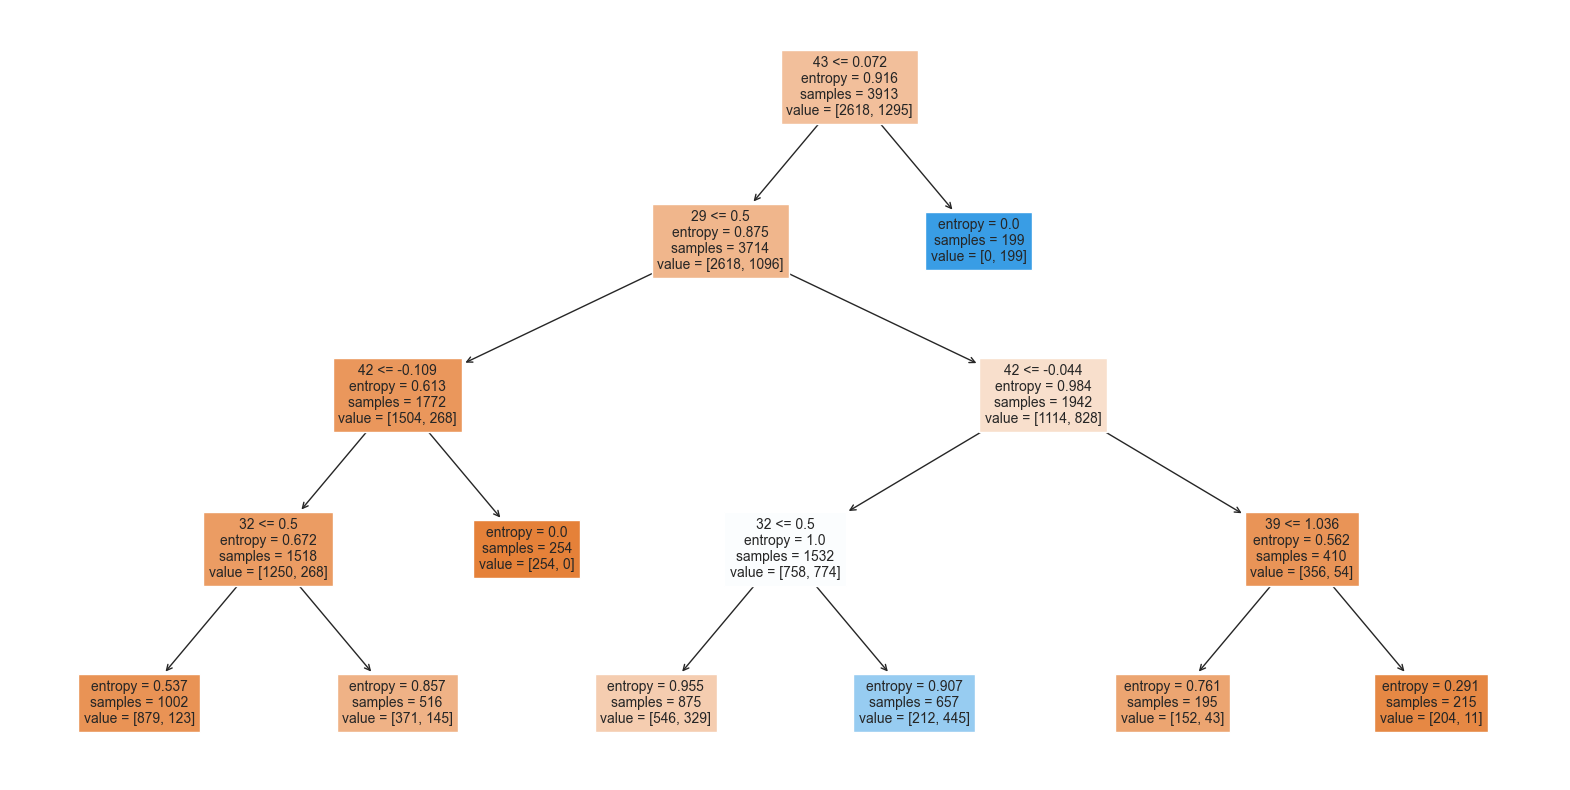

In [87]:
plt.figure(figsize=(20, 10))
plot_tree(best_clf, fontsize=10, feature_names=list(X), filled=True)
plt.show()

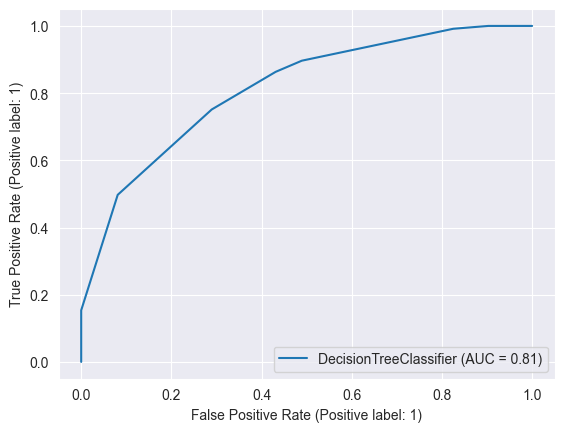

In [88]:
plot_roc_curve(best_clf, X_test, y_test)
plt.show()

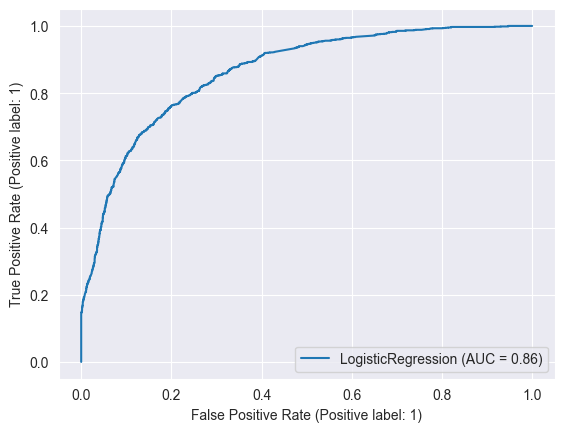

In [69]:
plot_roc_curve(clf, X_test, y_test)
plt.show()

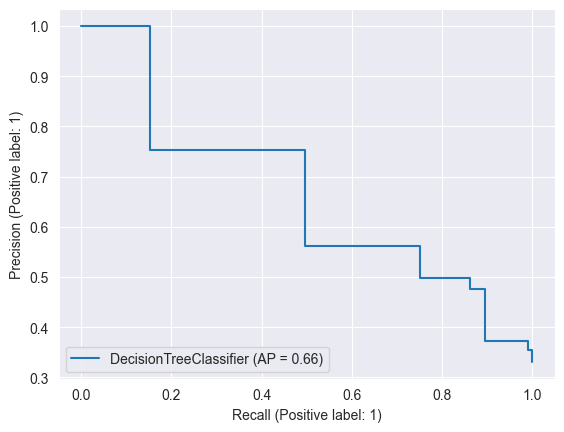

In [63]:
plot_precision_recall_curve(best_clf, X_test, y_test)
plt.show()

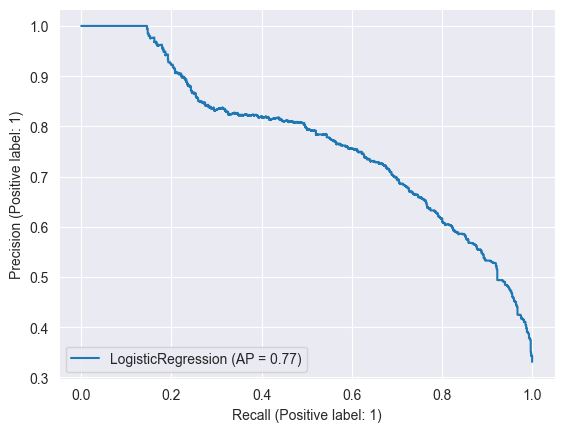

In [70]:
plot_precision_recall_curve(clf, X_test, y_test)
plt.show()

In [71]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [64]:
test_prob1 = best_clf.predict_proba(X_test)[:, 1]
test_pred1 = best_clf.predict(X_test)

In [65]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob1)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob1)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob1)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred1)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred1)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred1)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred1)))

print('\nClassification Report')
print(classification_report(y_test, test_pred1))

Log loss = 0.46469
AUC = 0.81363
Average Precision = 0.66491

Using 0.5 as threshold:
Accuracy = 0.77945
Precision = 0.75234
Recall = 0.49730
F1 score = 0.59879

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2618
           1       0.75      0.50      0.60      1295

    accuracy                           0.78      3913
   macro avg       0.77      0.71      0.72      3913
weighted avg       0.78      0.78      0.77      3913



In [72]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.42315
AUC = 0.86313
Average Precision = 0.76914

Using 0.5 as threshold:
Accuracy = 0.80501
Precision = 0.71556
Recall = 0.68185
F1 score = 0.69830

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2618
           1       0.72      0.68      0.70      1295

    accuracy                           0.81      3913
   macro avg       0.78      0.77      0.78      3913
weighted avg       0.80      0.81      0.80      3913



Confusion Matrix


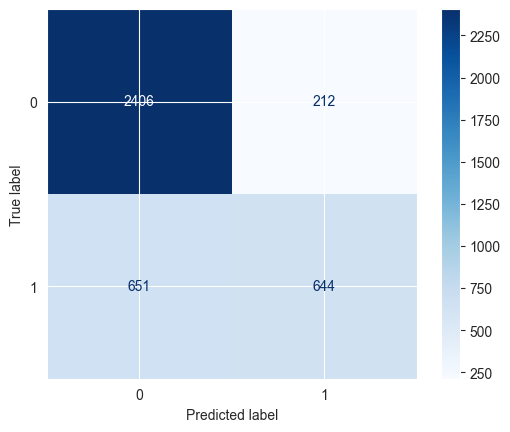

[[2406  212]
 [ 651  644]]
<class 'numpy.ndarray'>


In [67]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred1)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

Confusion Matrix


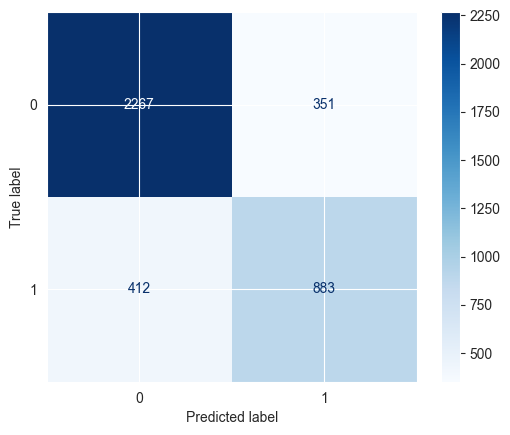

[[2267  351]
 [ 412  883]]
<class 'numpy.ndarray'>


In [73]:
print('Confusion Matrix')
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()
print(conf_matrix)
print(type(conf_matrix))

In [858]:
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

,variable,coefficient
0,intercept,-3.346211
1,cargo_count_1,0.839665
2,cargo_count_2,0.674202
3,cargo_count_3,0.578334
4,cargo_count_4,-0.075777
5,communication_method_phone,-0.753986
6,communication_method_whatsapp,-1.096975
7,discount_1,-2.531203
8,discount_10,0.480745
9,discount_2,0.176707


In [859]:
df_dummy['status_id'].value_counts()

0    2498
1    1236
Name: status_id, dtype: int64

In [860]:
x_result = pd.DataFrame()
x_result['fact'] = df_dummy['status_id']
x_result['predict'] = test_pred
x_result['result'] = x_result.fact - x_result.predict
x_result = x_result['result'].value_counts()
x_result.index = ['Match', 'False-Negative', 'False-Positive']
x_result = pd.concat([x_result, x_result / sum(x_result)], axis=1)
x_result

,result,result
Match,2994,0.801821
False-Negative,404,0.108195
False-Positive,336,0.089984
